In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
data_t= !unzip '/content/drive/MyDrive/training/asl_alphabet_train.zip'

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import pickle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import datasets
from keras import models
from keras.models import Sequential
from keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize



In [ ]:

DATA_DIR = '/content/asl_alphabet_train/asl_alphabet_train'

labels = []
imagg = []

class_map = {dir_: idx for idx, dir_ in enumerate(sorted(os.listdir(DATA_DIR)))}

for dir_ in os.listdir(DATA_DIR):
    for img_path in os.listdir(os.path.join(DATA_DIR, dir_)):

        img_ = os.path.join(DATA_DIR, dir_, img_path)
        # Load images as numpy array
        img = cv2.imread(img_)
        imagg.append(img)

        # Get the class number using the dictionary
        classnum = class_map[dir_]
        labels.append(classnum)


# pickle file to save the data
with open('data.pickle', 'wb') as f:
    pickle.dump({'data': imagg, 'labels': labels}, f)






In [ ]:

data_dict = pickle.load(open('./data.pickle', 'rb'))
data1 = np.asarray(data_dict['data'])
labels1 = np.asarray(data_dict['labels'])



In [ ]:
#splitting the dataset
x_train, x_test, y_train, y_test = train_test_split(data1, labels1, test_size=0.2, shuffle=True, stratify=labels)


In [ ]:
# Normalization
x_train, x_test=x_train / 255.0, x_test / 255.0

In [ ]:
# resize the images from 200 to 128
x_train = tf.image.resize(x_train, (128, 128))
x_test = tf.image.resize(x_test, (128, 128))

In [ ]:
#uploading previously trained model
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3),
                                               include_top=False,
                                               weights='imagenet')
#freezing the base model layers to avoid destroying the learned info
for layer in base_model.layers:
    layer.trainable = False
# creating model on top of the layers
inputs = keras.Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(29, activation='softmax')(x)

# Combine base model and custom head into a single model
model = keras.Model(inputs, outputs=predictions)



#scheduling learning rate
reduce_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
#fitting the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history=model.fit(x_train, y_train, epochs=1,
                    validation_data=(x_test, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


533/533 [==============================] - 55s 99ms/step - loss: 0.0947 - accuracy: 0.9773 - val_loss: 0.0015 - val_accuracy: 1.0000


In [ ]:
# multi-class labels to a one hot encoded format
y_test_onehot = label_binarize(y_test, classes=np.arange(29))

y_pred_proba = model.predict(x_test)

fpr = dict()#False pos
tpr = dict()#True pos
roc_auc = dict()#ROC
n_classes = 29

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 8))
colors = plt.cm.get_cmap('tab20', n_classes)

for i, color in zip(range(n_classes), colors.colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0.5))
plt.show()

In [ ]:
#fine tuning
#unfreezing the layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history_fine=model.fit(x_train, y_train, epochs=2, validation_data=(x_test, y_test))




Epoch 1/2
533/533 [==============================] - 61s 107ms/step - loss: 0.0250 - accuracy: 0.9937 - val_loss: 0.0060 - val_accuracy: 0.9979
Epoch 2/2
533/533 [==============================] - 55s 103ms/step - loss: 0.0056 - accuracy: 0.9988 - val_loss: 0.0127 - val_accuracy: 0.9962


134/134 [==============================] - 10s 76ms/step


<ipython-input-23-1dc2d6eae43b>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', n_classes)


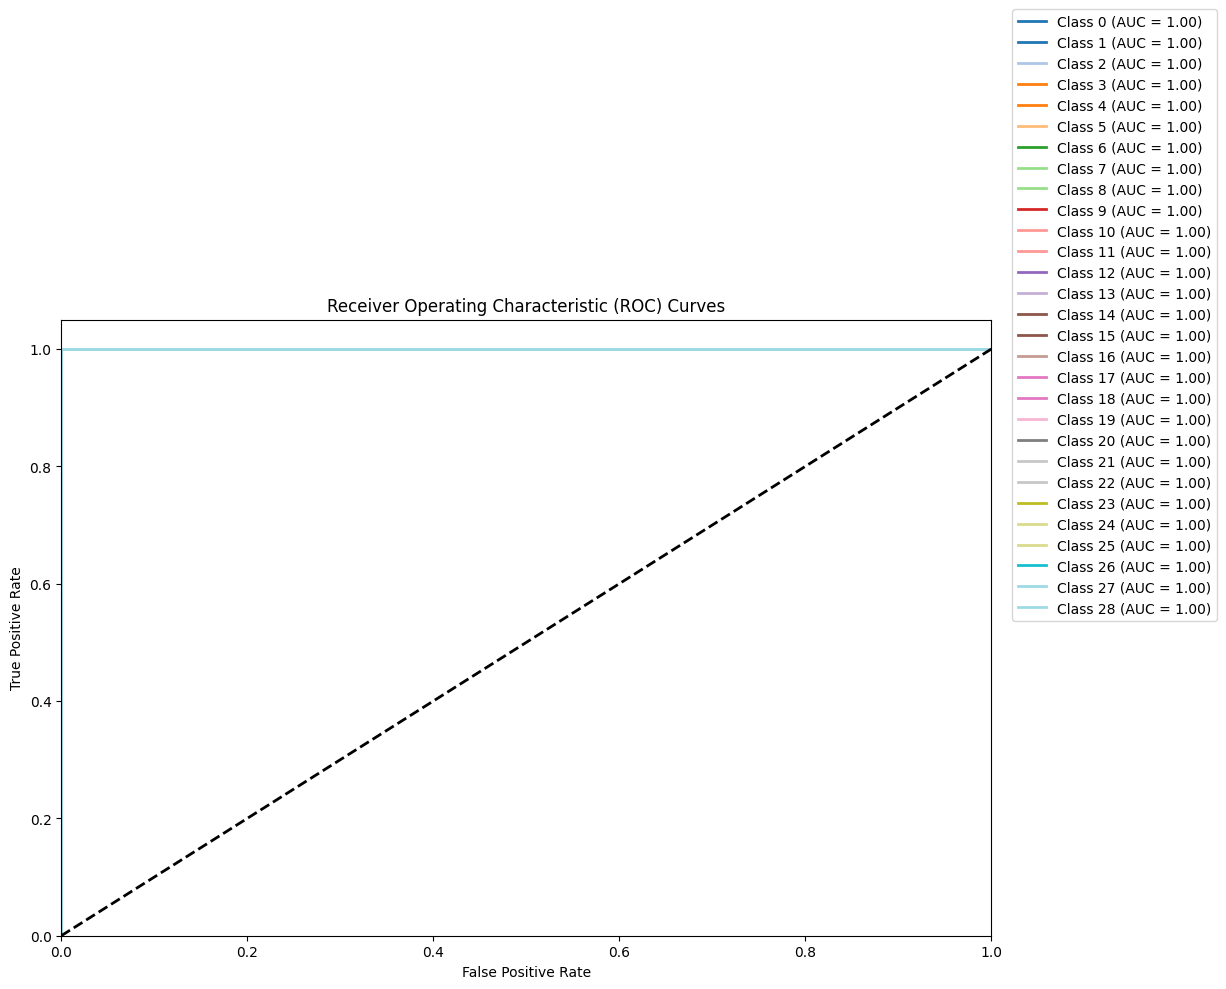

In [ ]:

y_test_onehot = label_binarize(y_test, classes=np.arange(29))

y_pred_proba = model.predict(x_test)

fpr = dict()#False pos
tpr = dict()#True pos
roc_auc = dict()#ROC
n_classes = 29

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 8))
colors = plt.cm.get_cmap('tab20', n_classes)

for i, color in zip(range(n_classes), colors.colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0.5))
plt.show()

In [ ]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate F1 scores for each class
f1_scores = f1_score(y_test, y_pred_classes, average=None, labels=np.arange(29))

# Plotting the F1 scores
plt.figure(figsize=(12, 8))
plt.bar(range(29), f1_scores, color='skyblue')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score per Class')
plt.xticks(range(29))
plt.ylim([0, 1])
plt.show()

In [ ]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

In [ ]:
import random

1/1 [==============================] - 0s 34ms/step


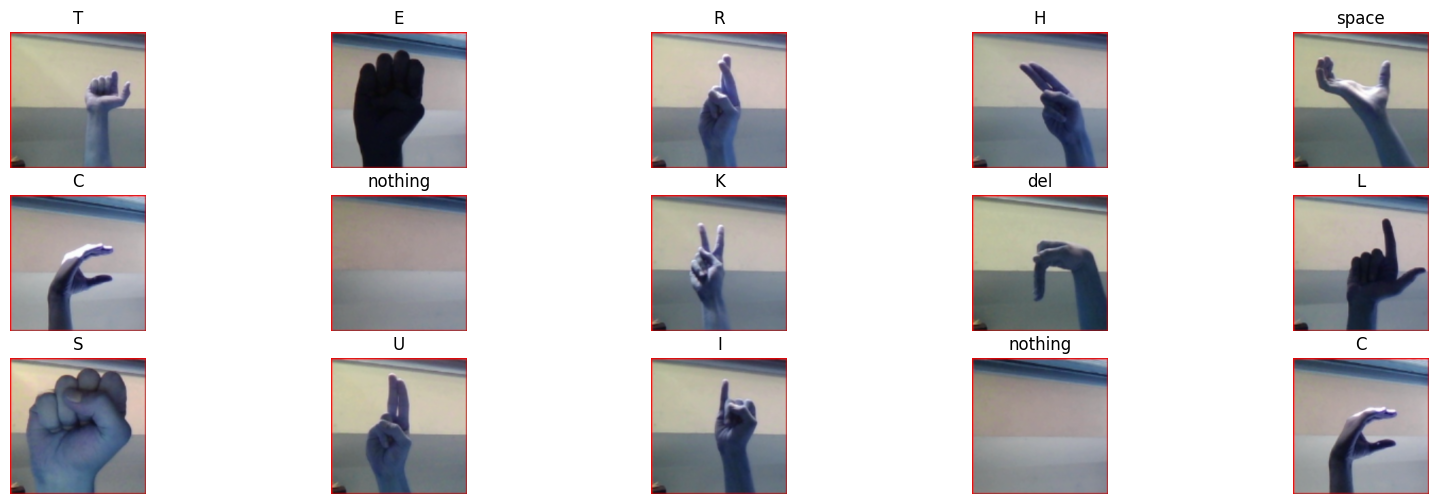

In [ ]:
plt.figure(figsize=(20, 6))
for i in range(15):
    random_index = random.randint(0, len(x_test) - 1)

    # Resize the selected image
    x_tet = tf.image.resize(x_test[random_index], (200, 200))

    # Predict the class of the selected image
    pred = model.predict(x_test[random_index].reshape(1, 128, 128, 3))
    predicted_class = np.argmax(pred)

    # Get the corresponding letter from the class_map
    key = [k for k, v in class_map.items() if v == predicted_class][0]

    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(x_tet)
    plt.title(key)
    plt.axis("off")

plt.show()